In [1]:
library(ggplot2)
library(maps)
library(readr)
library(dplyr)
library(RColorBrewer)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
LAT1 = 72 ; LAT2 = 34
LON1 = -12 ; LON2 = 40

In [7]:
occ.cornix <- read_tsv("./data/GBIF_Corvus_corone_cornix.zip")
occ.cornix <- occ.cornix[
  !is.na(occ.cornix$decimalLatitude) &
  !is.na(occ.cornix$decimalLongitude), ]

occ.corone <- read_tsv("./data/GBIF_Corvus_corone_corone.zip")
occ.corone <- occ.corone[
  !is.na(occ.corone$decimalLatitude) &
  !is.na(occ.corone$decimalLongitude), ]


Parsed with column specification:
cols(
  .default = col_character(),
  gbifID = col_double(),
  verbatimScientificNameAuthorship = col_logical(),
  locality = col_logical(),
  stateProvince = col_logical(),
  individualCount = col_double(),
  decimalLatitude = col_double(),
  decimalLongitude = col_double(),
  coordinateUncertaintyInMeters = col_double(),
  coordinatePrecision = col_logical(),
  elevation = col_logical(),
  elevationAccuracy = col_logical(),
  depth = col_logical(),
  depthAccuracy = col_logical(),
  eventDate = col_datetime(format = ""),
  day = col_double(),
  month = col_double(),
  year = col_double(),
  taxonKey = col_double(),
  speciesKey = col_double(),
  institutionCode = col_logical()
  # ... with 11 more columns
)

See spec(...) for full column specifications.

Warning message:
“974972 parsing failures.
 row                              col           expected         actual                                   file
7588 verbatimScientificNameAuthorship 1/0/T/F

In [8]:
nrow(occ.cornix)
nrow(occ.corone)

occ.cornix.sampled <-
   occ.cornix[sample(nrow(occ.cornix), 50000),]

occ.corone.sampled <-
   occ.corone[sample(nrow(occ.corone), 50000),]


[1] 257874

[1] 85218

In [80]:
occ.cornix.sampled$x = round(occ.cornix.sampled$decimalLongitude)
occ.cornix.sampled$y = round(occ.cornix.sampled$decimalLatitude)
tally.cornix <- occ.cornix.sampled %>%
    group_by(x,y) %>%
    tally()
tally.cornix <- data.frame(tally.cornix)

occ.corone.sampled$x = round(occ.corone.sampled$decimalLongitude)
occ.corone.sampled$y = round(occ.corone.sampled$decimalLatitude)
tally.corone <- occ.corone.sampled %>%
    group_by(x,y) %>%
    tally()
tally.corone <- data.frame(tally.corone)

In [108]:
occ.all.sampled <- rbind(occ.cornix.sampled, occ.corone.sampled)
occ.all.sampled$x = round(occ.all.sampled$decimalLongitude)
occ.all.sampled$y = round(occ.all.sampled$decimalLatitude)
tally.all <- occ.all.sampled %>%
    group_by(x,y) %>%
    tally()
tally.all <- data.frame(tally.all)

In [139]:
tally.all$cornix.n <- rep(0, nrow(tally.all))
tally.all$corone.n <- rep(0, nrow(tally.all))

for (i in 1:nrow(tally.all)) {
    all.x = tally.all[i, "x"]
    all.y = tally.all[i, "y"]
    n1 <- filter(tally.cornix, tally.cornix$x == all.x & tally.cornix$y == all.y)$n
    if (length(n1)) {
        tally.all$cornix.n[i] <- n1
    }
    n2 <- filter(tally.corone , tally.corone$x == all.x & tally.corone$y == all.y)$n
    if (length(n2)) {
        tally.all$corone.n[i] <- n2
    }
}

# 1 -> 100% cornix, -1 -> 100% corone, 0 -> 50% each
tally.all$odds <- (tally.all$cornix.n - tally.all$corone.n)/tally.all$n

head(tally.all)

range(tally.all$odds)

x    y  n  cornix.n corone.n odds      
1 -110 23  1 1         0        1.0000000
2  -29 39  2 1         1        0.0000000
3  -28 38 19 2        17       -0.7894737
4  -28 39  8 3         5       -0.2500000
5  -27 39 18 4        14       -0.5555556
6  -26 38 25 5        20       -0.6000000

[1] -1  1

In [161]:

world_df <- map_data("world")

# a diverging color scale
scale <- scale_fill_gradientn(
    colors = brewer.pal(10,"RdYlGn"), 
    breaks=c(1, 0, -1),
    labels = c("100% C. cornix", "50% C. cornix, 50% C. corone", "100% C. corone"))

proj <- coord_map(projection="albers", parameters=c(mean(LON2, LON1), mean(LAT1, LAT2)))

Warning message:
“Removed 40 rows containing missing values (geom_tile).”
Warning message:
“Removed 84110 row(s) containing missing values (geom_path).”


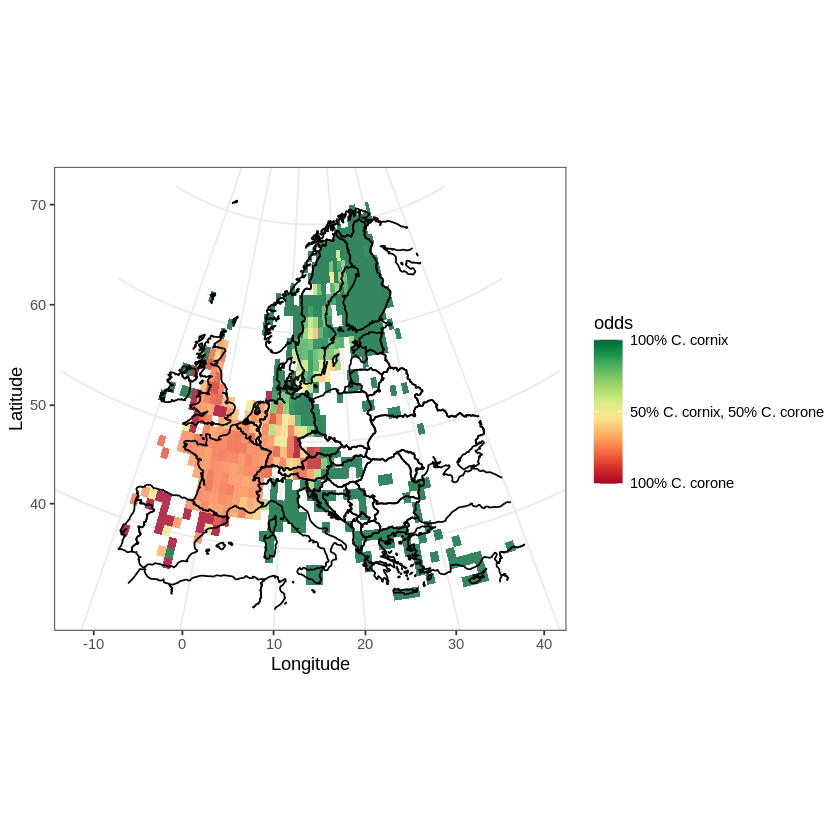

In [162]:
ggplot(tally.all) +
    geom_tile(aes(x, y, fill=odds), alpha=0.8) +
    geom_path(aes(x = long, y = lat, group=group), data = world_df) +
    xlim(c(LON1, LON2)) + ylim(c(LAT2, LAT1)) + 
    theme_bw() +
    labs(x="Longitude", y="Latitude") +
    scale +
    proj